In [1]:
## GMM: K-MEANS는 특정 중심점을 기반으로 거리적으로 퍼져있는 데이터 세트에 대해 효율적
## 그런게 아닌 경우, 특히 데이터가 얇고 긴 군집들로 구성이 되는 경우 효율적
## 데이터가 여러개의 다른 가우시안 분포를 가지는 모델로 가정하고, 다 돌려본다음에 어디에 속하는지를 결정
## 이걸 정하는게 모수추정: EM(Expectation and Maximization) 기법으로 추정함

# GMM을 이용한 IRIS 데이터 군집화
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [10]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

irisDF['gmm_cluster'] = gmm_cluster_labels

iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       1              45
        2               5
2       2              50
Name: gmm_cluster, dtype: int64


In [6]:
# k-means를 써보자

iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [12]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels

iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       2                 48
        0                  2
2       0                 36
        2                 14
Name: kmeans_cluster, dtype: int64


In [14]:
## 시각화 함수(하나하나당 의미는 차차 알아가자)
# iscenter=군집점, default는 True, gmm은 군집점이 따로 없어서 false
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter:
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False
    
    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name] == label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else:
            cluster_legend = 'Cluster' + str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70, 
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        # 군집점이 있는 경우 군집점 추가
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
            
    if isNoise:
        legend_loc = 'upper center'
    else:
        legend_loc = 'upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()
    
    

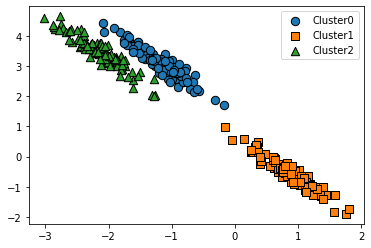

In [16]:
## 타원형으로 늘어선 임의의 데이터 세트 형성
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# x 데이터에 아래 좌표값들 내적하면 타원형 데이터가 생성됨
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# 실제 target 값으로 아무 기법 안쓰고 늘여놓으면 저렇게 결과값이 분류가 되어야 함
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

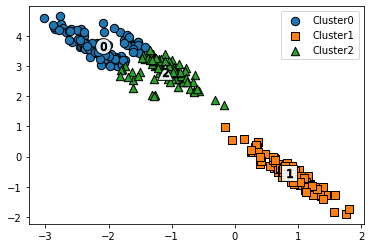

In [17]:
# 방법1: kmeans, 잘안되는걸 알 수 있다. 
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

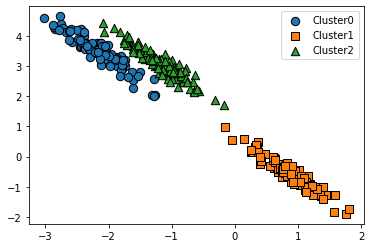

In [24]:
# 3개의 n_components기반 GMM을 X_aniso 데이터 셋에 적용 
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정. 
visualize_cluster_plot(gmm, clusterDF, 'gmm_label',iscenter=False)


In [25]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: kmeans_label, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: gmm_label, dtype: int64
